# PFC Self-Admin | Population Analysis

### Import libraries and modules

In [1]:
# System-level and data processing imports
import os
import numpy as np
import scipy.stats as stats
import scipy.io as sio
from sklearn.metrics import roc_auc_score as auROC

# Visualization imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Define sample extraction parameters

In [2]:
alphalevel = 0.05
mineventstoanalyze = 2
separation_requirement = 1000 # 1s

frameaveraging = 4
framerate = 30
timebetweenframes = 1000 / framerate # FIXME: Adjusted for precision; original was hard-coded to 33.3333
averagedframerate = framerate / frameaveraging

pre_window_size = int(10 * averagedframerate)
window_size =  int((pre_window_size * 2) + (1.6 * averagedframerate))
post_window_size = window_size - pre_window_size

baselinefirstframe = 0
baselinelastframe = int(3 * averagedframerate)
infusionframe = int(pre_window_size + (1.6 * averagedframerate))
aucfirstframe = int(pre_window_size - (5 * averagedframerate))
auclastframe = int(pre_window_size + (5 * averagedframerate))

basedir = '../data'

### Define utility functions for stats and data handling

In [3]:
def calculate_auROC(x, y, offset_to_zero=True):
    """
    Function: Compute shifted AUROC and Mann-Whitney p-value
    Input: x/y (1D arrays, e.g., response/baseline values)
    Transformation: Clean NaNs from x/y; if empty, return NaNs. Compute MWU p; concat labels/data for AUROC; shift if offset. Output: (shifted_AUC, p)
    """

    print(f"---> Calculating AUROC")
    x_clean = x[~np.isnan(x)] # FIXME: Added these lines to remove NaNs from input arrays; transforms x to non-NaN subset (shape: variable length)
    y_clean = y[~np.isnan(y)]

    # Check if cleaned arrays are empty; if so, return NaNs (no transformation possible)
    if len(x_clean) < 1 or len(y_clean) < 1:
        return np.nan, np.nan

    # Attempt MWU test; transforms cleaned data into U statistic and p-value
    try:
        U, p = stats.mannwhitneyu(x_clean, y_clean) # perform Mann-Whitney U test; output p is significance
    except ValueError:
        return np.nan, np.nan

    # Create labels (1s for x, 0s for y) and concat data; transforms to binary classification setup for AUROC
    labels = np.concatenate((np.ones(len(x_clean)), np.zeros(len(y_clean))))
    data = np.concatenate((x_clean, y_clean))

    # Compute AUROC; transforms concatenated data/labels into area under curve (A)
    try:
        A = auROC(labels, data) # calculate ROC AUC
    except ValueError:
        return np.nan, np.nan

    # Optional shift: Transforms A from [0,1] to [-1,1] if offset=True
    if offset_to_zero:
        return 2 * (A - 0.5), p
    else:
        return (A, p)

def Benjamini_Hochberg_correction(vector_of_pvals, alpha = 0.05):
    """Function: Benjamini-Hochberg FDR correction
    Input: vector_of_pvals (1D array)
    Transformation: Sort pvals, find rejection threshold, set non-sig to 1, preserve NaNs. Output: corrected pvals array (same shape)"""

    print(f"---> Applying Benjamini-Hochberg FDR correction")
    sortedpvals = np.sort(vector_of_pvals) # Sort pvals ascending; transforms unsorted to sorted
    orderofpvals = np.argsort(vector_of_pvals) # Get original indices for resorting
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] # Count finite pvals (total hypotheses); filters NaN/inf
    for i in range(m):
        if sortedpvals[i] > (i + 1) * alpha / m: # Check threshold; transforms to find max k for rejection
            k = i
            break
        elif i == m - 1:
            k = m - 1
    correctedpvals = np.copy(vector_of_pvals) # Copy input; base for output
    correctedpvals[orderofpvals[k:]] = 1 # Set non-sig to 1 using original order
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan # Preserve original NaNs
    return correctedpvals

def iterate_dirs(basedir, days):
    """Function: Directory iterator generator
    Input: basedir, days list
    Transformation: Yields paths (basedir, day, animal, fov); no data transform, just traversal"""

    for day in sorted(days):
        animals = next(os.walk(os.path.join(basedir, day)))[1]
        for animal in sorted(animals):
            FOVs = next(os.walk(os.path.join(basedir, day, animal)))[1]
            for fov in sorted(FOVs):
                yield basedir, day, animal, fov


### Define utility functions for frame handling

In [4]:
def framenumberforevent(event, frame_timestamps):
    """Function: Map event timestamps to frame numbers
    Input: event (1D timestamps), frame_timestamps (1D)
    Transformation: For each e, find last index where frame_ts <= e (nearest prior frame); set NaN/0 if invalid. Output: framenumber array (same shape as event)"""

    print(f"---> Mapping events to frames, n={len(event)}")
    framenumber = np.nan * np.zeros(event.shape) # Init NaN array same shape as event
    for ie, e in enumerate(event):
        if np.isnan(e):
            # framenumber[ie] = np.nan # FIXME: Preserves the NaNs; should be 0 for stability when normalizing
            framenumber[ie] = 0
            continue
        else:
            temp = np.nonzero(frame_timestamps <= e)[0] # Find indices <= e; transforms to subset indices
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps <= e)[0][-1] # Take last (nearest); single value
            else:
                framenumber[ie] = 0 # Default to 0 if no match
    return framenumber

def fix_any_dropped_frames(frame_timestamps):
    """Function: Correct dropped frames by inserting missed timestamps
    Input: frame_timestamps (1D)
    Transformation: Add first/last frames; detect gaps >1 frame, insert interpolated ts using round and int; sort. Output: corrected array (longer if misses)"""

    print(f"---> Fixing dropped frames, n={len(frame_timestamps)}")
    first_frame = np.array([0]) # Add 0 as first
    last_frame = np.array([int(np.max(frame_timestamps) + (500 * timebetweenframes))]) # Add extended last
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) # Concat; transforms to extended array
    frames_missed = []
    for i in range(len(frame_index_temp) - 1):
            numframes_missed = int(np.round((frame_index_temp[i + 1] - frame_index_temp[i]) / timebetweenframes) - 1) # Calc misses via round
            if numframes_missed > 0:
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j + 1)))]) # Insert int-multiples
                    frames_missed = np.concatenate((frames_missed, frame_missed)) # Append to list
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed)))) # Concat and sort; final corrected
    return corrected_frame_index

def fix_assumed_frames(frames):
    """Function: Alternative dropped frame correction (assumed)
    Input: frames (1D timestamps)
    Transformation: Detect diffs >1.5*interval, insert multiples; sort. Output: corrected array (longer)"""

    print(f"Fixing assumed dropped frames, n={len(frames)}")
    dropped_frames = []
    diff_frames = np.diff(frames) # Compute differences; transforms to diffs array
    frame_drop_idx = np.where(diff_frames> 1.5 * timebetweenframes)[0] # FIXME: Original casts int() on timebetweenframes yielding 33; less precise
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx + 1] - frames[idx]) / (timebetweenframes + 0.0)) - 1) # Calc drops
        temp = [frames[idx] + a * timebetweenframes for a in range(1, numframesdropped + 1)] # Generate inserts
        dropped_frames.extend(temp) # Append to list
    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames)))) # Concat and sort
    return corrected_frames

### Prepare assumed frame timestamps from empty.mat

In [5]:
behaviordata_noframes = sio.loadmat('../data/empty.mat') # Load dummy eventlog
eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog']) # [events,2]

max_of_eventlog_noframes = max(eventlog_noframes[:,1]) # Max ts
length_of_eventlog_noframes = len(eventlog_noframes[:,1]) # Length
x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes)) # Triplicate vertically
x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1] + max_of_eventlog_noframes # Offset second copy
x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes * 2:,1] + (2 * max_of_eventlog_noframes) # Offset third

eventlog_noframes = x # Extended [3*len,2]

assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:, 0] == 9, 1]) # Alt fix

Fixing assumed dropped frames, n=87549


### Core session analysis functions

In [6]:
def calculate_aligneddata_forevent(signalsT2, events2, frame_timestamps, numrois):
    framenumberfor_eventofinterest = np.squeeze(framenumberforevent(events2, frame_timestamps)) # Map to indices [trials]
    numtrials = framenumberfor_eventofinterest.shape[0]
    alignedevents = np.nan * np.zeros([numtrials,window_size,numrois]) # Init nan 3D
    print(f"---> Aligning events, n={numtrials}")
    for i in np.flip(range(numtrials)): # Reverse to delete safely
        eventindex = framenumberfor_eventofinterest[i]
        if np.isfinite(eventindex) and eventindex > pre_window_size and eventindex < np.shape(signalsT2)[0] - post_window_size:
            eventindex = int(eventindex)
            alignedevents[i, :, :] = signalsT2[eventindex-pre_window_size:eventindex+post_window_size, :] # Slice window [win, ROIs]
        else:
            alignedevents = np.delete(alignedevents, i, axis = 0) # Delete invalid row; shortens trials dim
    return alignedevents

def adjust_frame_timestamps(animal, eventlog, assumed_frame_timestamps):
    if animal in ['CTL1', 'ER-L1', 'ER-L2', 'IG-19', 'IG-28', 'PGa-T1', 'XYZ']:
        frame_timestamps = np.array(assumed_frame_timestamps) # Use pre-computed assumed timestamps
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:, 0]== 9, 1]) # Fix from id9 ts
    frame_timestamps = frame_timestamps[::frameaveraging] # Downsample every 4th; reduces length /4
    return frame_timestamps

def analyze_single_session(indir, window_size, assumed_frame_timestamps):
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' in f] # List .npy files
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat'] # List .mat files

    print(f"---> Compiling MATLAB files, n={len(matfiles)}")
    print(f"---> Compiling NumPy files, n={len(npyfiles)}")
    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' in f and not 'part2' in f and not 'part3' in f and not 'part4' in f]
        npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and not 'results' in f and not 'part2' in f and not 'part3' in f and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]

    signals = np.squeeze(np.load(os.path.join(indir, npyfile))) # Load base signals; squeeze to [ROIs, frames]
    numrois = signals.shape[0]

    behaviordata = sio.loadmat(os.path.join(indir, matfile)) # Load base eventlog
    eventlog = np.squeeze(behaviordata['eventlog']) # [events, 2]: id, ts
    lastframe_timestamp_part1 = np.max(eventlog) # Max ts for offset
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2)))  # Load part2
        signals = np.hstack((signals, signals2)) # Hstack; extends frames
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1] + lastframe_timestamp_part1 # Offset ts
        eventlog = np.concatenate((eventlog,eventlog2)) # Concat events
        lastframe_timestamp_part2 = np.max(eventlog)
    if len(npyfiles) > 2:
        # Similar for part3: load, hstack signals, offset/concat eventlog
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3)))
        signals = np.hstack((signals, signals3))
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1] + lastframe_timestamp_part2
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
    if len(npyfiles) > 3:
        # Similar for part4
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4)))
        signals = np.hstack((signals, signals4))
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1] + lastframe_timestamp_part3
        eventlog = np.concatenate((eventlog,eventlog4))

    # Select and filter events of interest
    activelever = eventlog[eventlog[:, 0] == 22, 1] # Extract ts for id 22
    activelevertimeout = eventlog[eventlog[:, 0] == 222, 1] # For id 222

    temp = np.sort(np.hstack((activelever, activelevertimeout))) # Hstack and sort; combined sorted ts
    print(f"---> Total events: {len(temp)}")

    temp = np.delete(temp, np.argwhere(np.ediff1d(temp) < separation_requirement) + 1) # Filter close events; delete where diff <1000; transforms to separated ts
    print(f"---> Filtered events: {len(temp)}")

    events = temp # FIXME: Equivalent to "activeleverall"

    if len(events) < mineventstoanalyze: # FIXME: Moved here to return early if insufficient events
        print(f"---> Not enough events to analyze ({len(events)}), returning NaNs")
        # _ = np.nan * np.ones((2, window_size))
        _ = np.array([]) # FIXME: Changed to empty array to handle NaN inflation
        return _, _, _ # FIXME: Returns two rows of NaNs if insufficient events; inflates population stack

    # Fix frame timestamps
    frame_timestamps = adjust_frame_timestamps(animal, eventlog, assumed_frame_timestamps)

    # Trim signals if mismatched
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0] - 1]

    # Normalize signals (dF/F)
    print(f"---> Normalizing signals, n={numrois}")
    signals /= np.nanmean(signals, axis=1)[:, None] # Divide each row by its nanmean (over frames); transforms raw to relative changes

    # Z-score full trace per ROI
    print(f"---> Z-scoring signals per neuron, n={numrois}")
    # for n in range(signals.shape[0]):
    #     mean = np.nanmean(signals[n]) # Mean over row
    #     std = np.nanstd(signals[n]) # Std over row
    #     signals[n] = (signals[n] - mean) / std # FIXME: If std=0, will produce inf/NaN value inflating NaN's in population
    means = np.nanmean(signals, axis=1).reshape(-1, 1)  # shape: (num_neurons, 1)
    signals = np.divide( # FIXME: Normalizing trace ignoring where std=0
        signals,
        means,
        out=np.zeros_like(signals, dtype=np.float64),
        where=(means != 0) & (~np.isnan(means))
    )

    signalsT = signals.T # transpose signals to have ROIs as columns

    # Align events to signals
    alignedevents = calculate_aligneddata_forevent(signalsT, events, frame_timestamps, numrois)

    # Swap axes and mean over trials
    alignedevents = np.swapaxes(alignedevents, 0,2)
    popevents = np.nanmean(alignedevents, axis=2) # Mean over trials; reduces to [ROIs, win]

    return popevents, alignedevents, events

### Iterate directories and collect per-day popevents

> Data processing:
> - Filter by separation requirement
> - Normalize (dF/F)
> - Z-score per ROI using full trace
> - Baseline subtraction

In [8]:
tempdays = next(os.walk(os.path.join(basedir)))[1]
days = []
for t in tempdays: # Search for valid directories of data
    if t != 'Cascade' and t != 'CellTracking' and t != 'Codes' and t != '.ipynb_checkpoints' and t != 'Other' and t != 'Results':
        days = np.append(days, t)
numdays = len(days)

popevents_day = {}
popevents_fov = {}

for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
    if day not in popevents_fov:
        popevents_day[day] = np.nan * np.ones((1, window_size))  # Init nan row
        popevents_fov[day] = {}
    indir = os.path.join(basedir, day, animal, fov)

    print(f"Processing {day}, {animal}, {fov}")
    popevents, alignedevents, events = analyze_single_session(indir, window_size, assumed_frame_timestamps)
    if popevents.size != 0:
        popevents_day[day] = np.vstack((popevents_day[day], popevents))

    print(f"---> Performing baseline subtraction for {day}")
    popevents_day[day] = popevents_day[day][1:, :]  # Skip init nan row
    baseline = np.nanmean(popevents_day[day][:, baselinefirstframe:baselinelastframe], axis=1)
    popevents_day[day] = popevents_day[day] - baseline[:, None]
    print()

Processing 0 EarlyAcq, ER-L1, FOV1
---> Compiling MATLAB files, n=1
---> Compiling NumPy files, n=1
---> Total events: 16
---> Filtered events: 13
---> Normalizing signals, n=224
---> Z-scoring signals per neuron, n=224
---> Mapping events to frames, n=13
---> Aligning events, n=13
---> Performing baseline subtraction for 0 EarlyAcq

Processing 0 EarlyAcq, ER-L2, FOV1
---> Compiling MATLAB files, n=1
---> Compiling NumPy files, n=1
---> Total events: 16
---> Filtered events: 11
---> Normalizing signals, n=91
---> Z-scoring signals per neuron, n=91
---> Mapping events to frames, n=11
---> Aligning events, n=11
---> Performing baseline subtraction for 0 EarlyAcq

Processing 0 EarlyAcq, IG-19, FOV2
---> Compiling MATLAB files, n=1
---> Compiling NumPy files, n=1
---> Total events: 86
---> Filtered events: 56
---> Normalizing signals, n=85
---> Z-scoring signals per neuron, n=85
---> Mapping events to frames, n=56
---> Aligning events, n=56
---> Performing baseline subtraction for 0 EarlyA

### Compute AUC/pvals per day

In [9]:
# aucpvals_day = {}
# aucpvals_fov = {}
#
# for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
#     if day not in aucpvals_fov:
#         aucpvals_day[day] = np.nan * np.ones((1, 2))  # Init nan row
#         aucpvals_fov[day] = {}
#     indir = os.path.join(basedir, day, animal, fov)
#     popevents, alignedevents, events = analyze_single_session(indir, window_size,
#                                                               pre_window_size)  # Re-get aligned [ROIs, win, trials]
#     numrois = popevents.shape[0]
#     temp_aucpvals = np.nan * np.zeros((numrois, 2))  # Init [ROIs, 2] for AUC/p
#     for i in range(numrois):
#         baseline_data = alignedevents[
#             i, baselinefirstframe:baselinelastframe].flatten()  # Flatten baseline across trials [flat_len]
#         response_data = alignedevents[i, aucfirstframe:auclastframe].flatten()  # Flatten response [flat_len]
#         baseline_clean = baseline_data[~np.isnan(baseline_data)]  # Remove NaNs; shorter
#         response_clean = response_data[~np.isnan(response_data)]  # Shorter
#         if len(baseline_clean) > 0 and len(response_clean) > 0:
#             temp_aucpvals[i, 0], temp_aucpvals[i, 1] = calculate_auROC(response_data, baseline_data, offset_to_zero=True)  # Compute on flattened
#         else:
#             temp_aucpvals[i, 0], temp_aucpvals[i, 1] = np.nan, np.nan  # NaN if empty
#     aucpvals_day[day] = np.vstack((aucpvals_day[day], temp_aucpvals))  # Vstack [total_ROIs_day, 2]
#
# for day in sorted(days):
#     aucpvals_day[day] = aucpvals_day[day][1:, :]  # Skip init nan row

### Plotting and final normalizations

> Data Processing:
> - Z-score by baseline std per ROI
> - Mean over win per ROI
> - Sort descending
> - Plot imshow/mean trace

Z-scoring per ROI, day=0 EarlyAcq
Z-scoring per ROI, day=1 MidAcq
Z-scoring per ROI, day=2 LateAcq
Z-scoring per ROI, day=3 EarlyExt
Z-scoring per ROI, day=4 LastExt
Z-scoring per ROI, day=5 CueRein
Z-scoring per ROI, day=6 DrugRein
Z-scoring per ROI, day=7 TMTRein


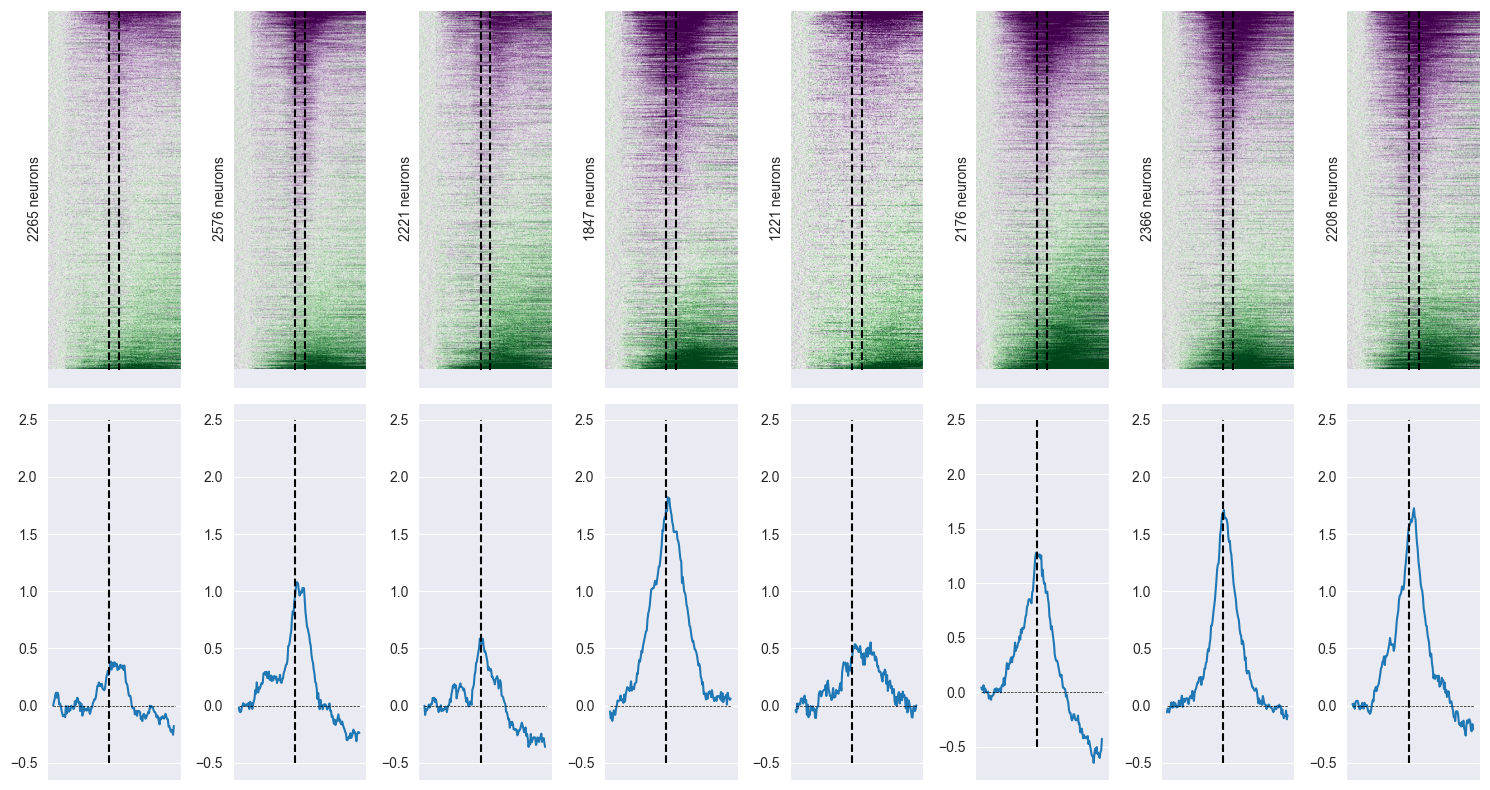

In [10]:
fig, axs = plt.subplots(2, numdays, figsize=(15, 8))
sns.set_style('white')

cmax = 4
cmin = -cmax

for d, day in enumerate(sorted(days)):
    temp = np.array(popevents_day[day]) # FIXME: Data still contains NaN inflation at this point
    temp = temp[~np.isnan(temp).any(axis=1)] # FIXME: Added this line to remove ROIs with NaN values
    temp_std = []

    # Z-score per ROI using baseline
    print(f"Z-scoring per ROI, day={day}")
    for neuron in range(temp.shape[0]):
        neuron_std = np.nanstd(temp[neuron, baselinefirstframe:baselinelastframe])
        temp_std = np.hstack((temp_std, neuron_std))
        temp[neuron, :] = temp[neuron, :] / neuron_std # Z-score whole row by baseline std; standardizes var

    tempresponse = np.nanmean(temp, axis=1) # Mean over win per ROI [ROIs]
    sort_descending = np.argsort(tempresponse)[::-1] # FIXME: Computations and sorting include inflated NaNs if not filtered
    numneurons_temp = len(tempresponse)

    ax = axs[0, d]
    im = ax.imshow(temp[sort_descending], cmap=plt.get_cmap('PRGn_r'), vmin=cmin, vmax=cmax, aspect='auto')

    ax.grid(False)
    ax.set_ylabel('%s neurons'%numneurons_temp)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.plot([pre_window_size, pre_window_size], [0, numneurons_temp], '--k', linewidth=1.5)
    ax.plot([infusionframe, infusionframe], [0, numneurons_temp], '--k', linewidth=1.5)

    ax = axs[1, d]
    ax.set_xticks([])
    ax.plot(np.nanmean(temp, axis=0))
    ax.plot([pre_window_size, pre_window_size], [-0.5,2.5],'--k', linewidth=1.5) # Event
    ax.plot([0, window_size], [0,0], '--k', linewidth=0.5)

fig.tight_layout()
plt.show()